In [1]:
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn
from PIL import Image
import os

In [2]:
from skimage import filters, color, morphology, io
import matplotlib.pyplot as plt
import numpy as np
import random
import skimage as si

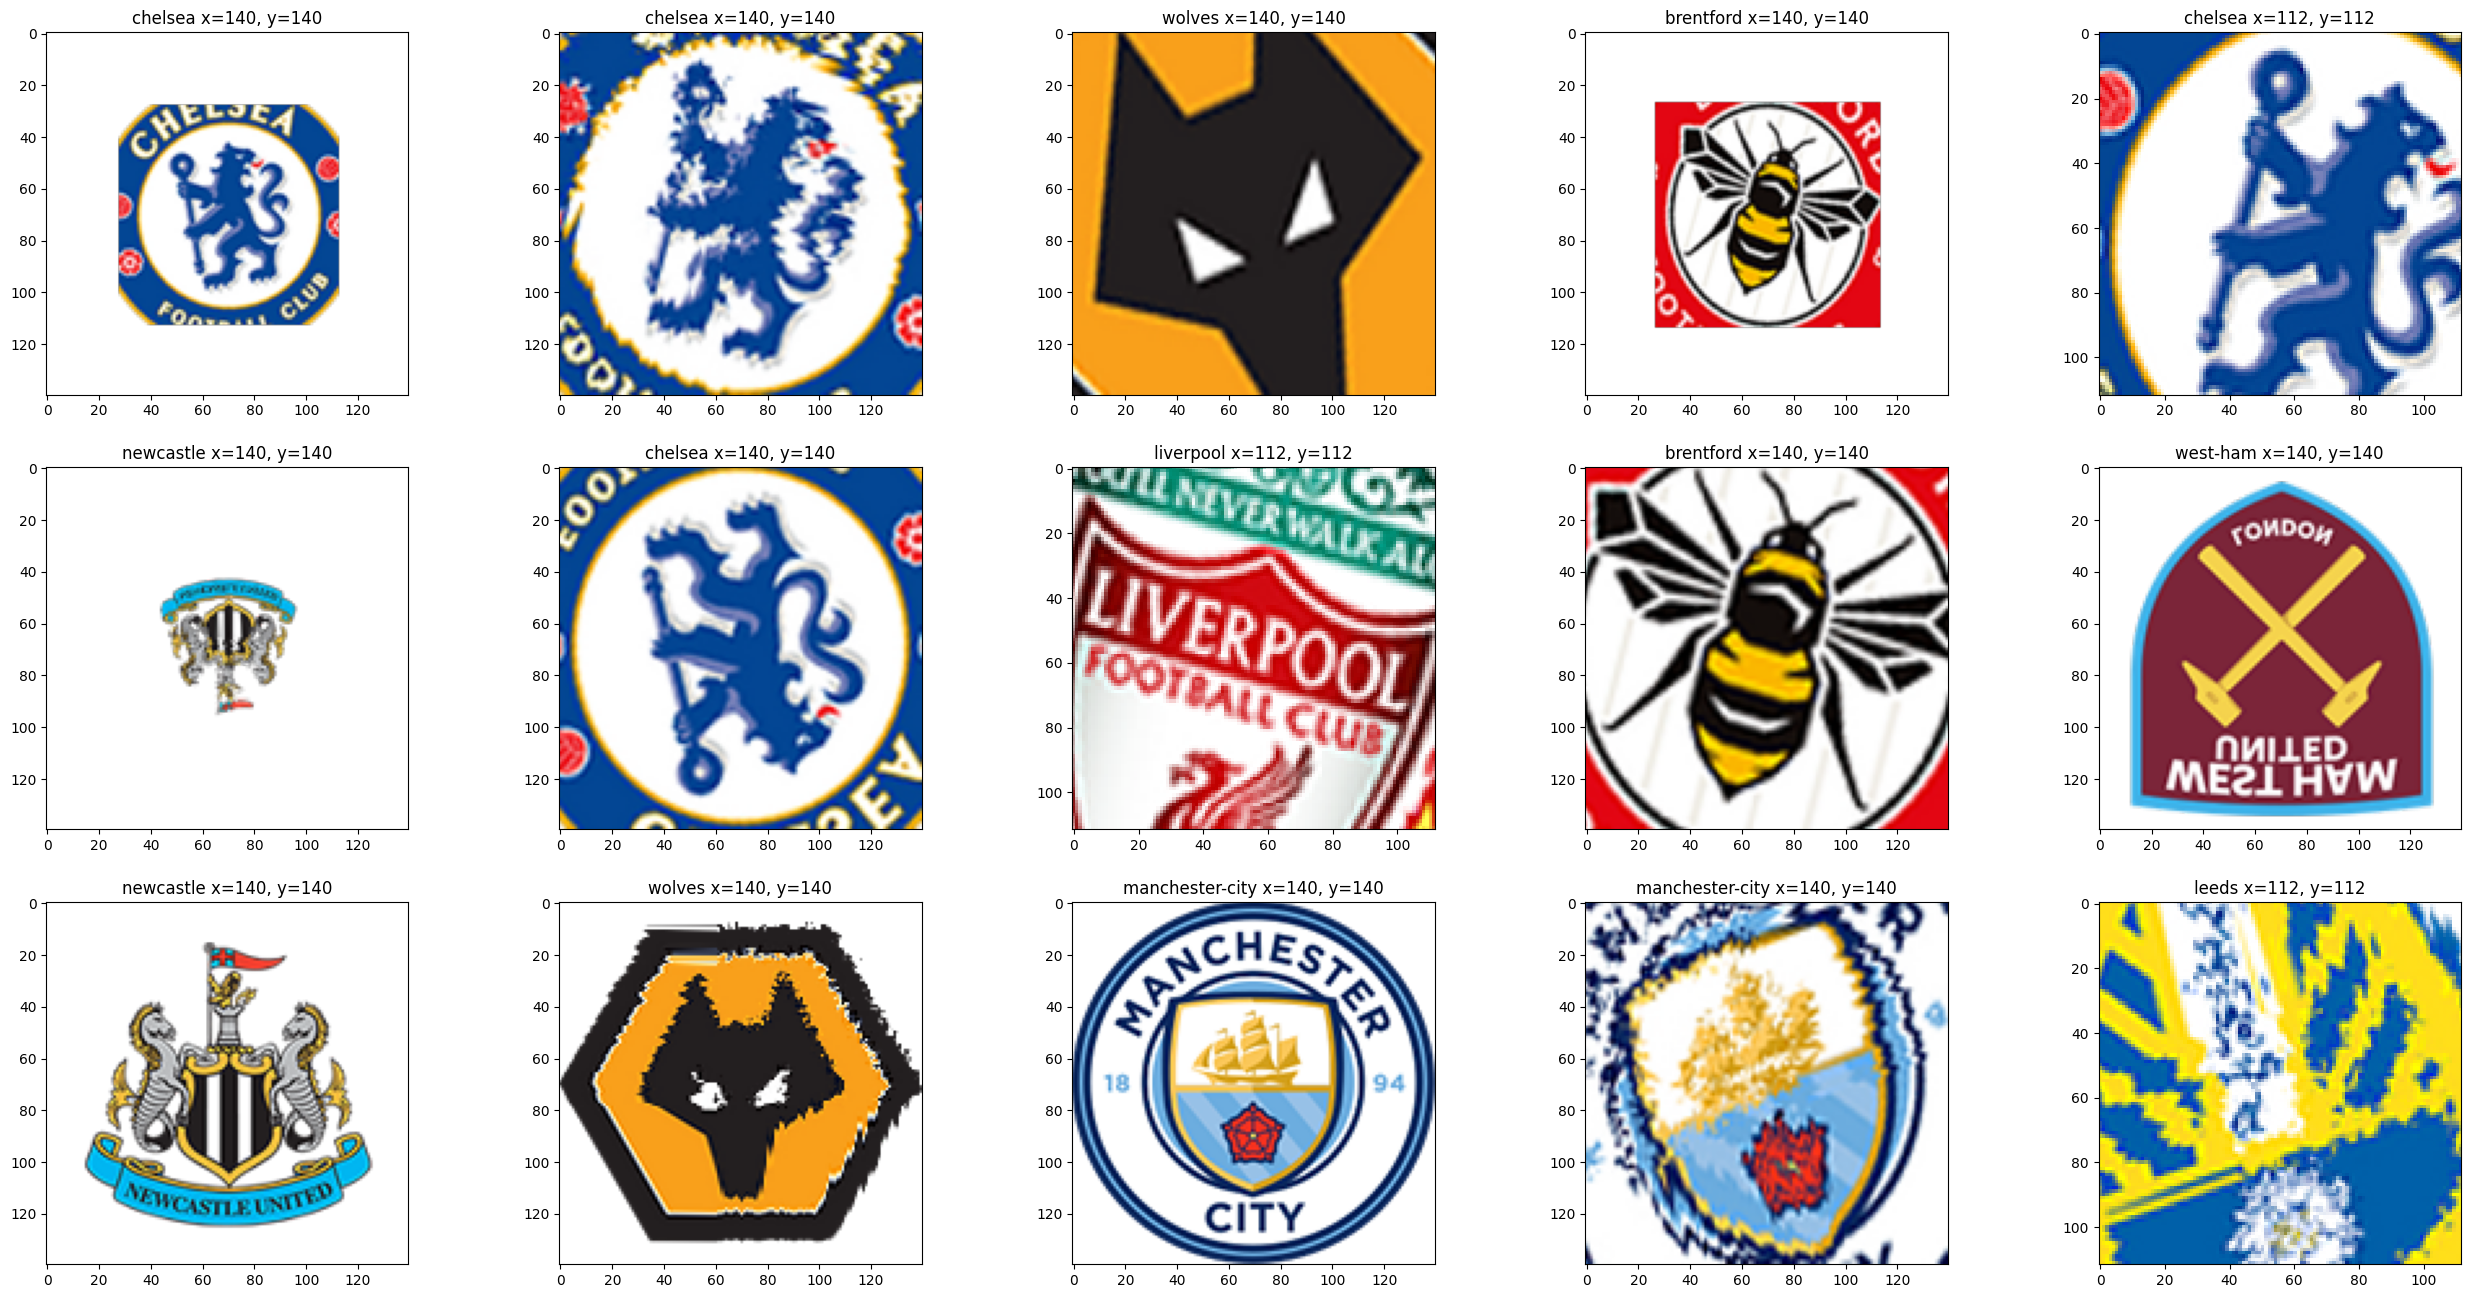

In [5]:
df = pd.read_csv("iinput/english-premier-league-logo-detection-20k-images/train.csv")

n1 = 3
n2 = 5
fig, axs = plt.subplots(n1, n2, figsize=(32, 16))
for i in range(n1):
    for j in range(n2):
        z = random.randint(0, len(df)-1)
        pic = np.array(io.imread(df.loc[z]["filepath"], plugin='pil'))
        shape = np.shape(pic)
        axs[i, j].imshow(pic)
        axs[i, j].set_title('%s x=%.f, y=%.f' % (df.loc[z]["team_name"], shape[0], shape[1]))

Average height 134.54


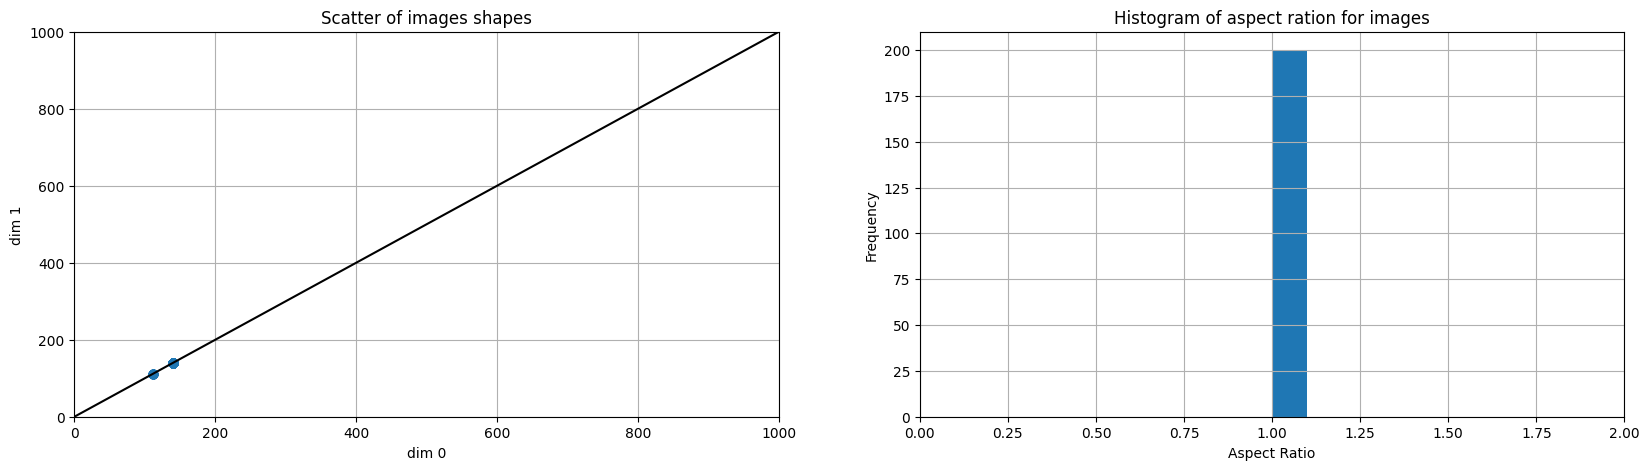

In [14]:
import numpy as np

sample_df = df.sample(frac=0.01, ignore_index=True)

N = len(sample_df)
shape = np.zeros((2, N))

for i in range(N):    
    tmp = np.shape(np.array(io.imread(sample_df.loc[i]["filepath"], as_gray=True, plugin='pil')))
    shape[:, i] = [tmp[0], tmp[1]]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(shape[0, :], shape[1, :])
axs[0].plot(range(0, 1000), range(0, 1000), 'k')
axs[0].set_ylabel('dim 1')
axs[0].set_xlabel('dim 0')
axs[0].grid()
axs[0].set_title('Scatter of images shapes')
axs[0].set_xlim([0, 1000])
axs[0].set_ylim([0, 1000])

axs[1].hist(shape[0, :]/shape[1, :])
axs[1].grid()
axs[1].set_xlabel('Aspect Ratio')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of aspect ration for images')
axs[1].set_xlim([0, 2])

print("Average height " + str(sum(shape[1, :]) / len(shape[1, :])))

In [24]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, X, y, BatchSize, transform):
    super().__init__()
    self.BatchSize = BatchSize
    self.y = y
    self.X = X
    self.transform = transform
    
  def num_of_batches(self):
    """
    Detect the total number of batches
    """
    return math.floor(len(self.list_IDs) / self.BatchSize)

  def __getitem__(self,idx):
    class_id = self.y[idx]
    img = Image.open(self.X[idx])
    img = img.convert("RGBA").convert("RGB")
    img = self.transform(img)
    return img, torch.tensor(int(class_id))

  def __len__(self):
    return len(self.X)

In [43]:

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms

# Shuffle dataframe
df = df.sample(frac=1)

X = df.iloc[:,0]
y = df.iloc[:,2]

transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.RandomRotation(20, fill=256),
                transforms.ToTensor(),
                transforms.RandomAffine(degrees=0, translate=(0.025, 0.025), fill=256),
                transforms.Normalize([0.5], [0.5])
            ])

test_transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])

train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, stratify = y, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0)

dataset_stages = ['train', 'val', 'test']

batch_size = 32
image_datasets = {'train' : CustomDataset(X_train.values, y_train.values, batch_size, transform), 'val' : CustomDataset(X_val.values, y_val.values, batch_size, test_transform), 'test' : CustomDataset(X_test.values, y_test.values, batch_size, test_transform)}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=image_datasets[x].BatchSize,
                                            shuffle=True, num_workers=0)
            for x in dataset_stages}

dataset_sizes = {x: len(image_datasets[x]) for x in dataset_stages}

print(dataset_sizes)

{'train': 18000, 'val': 1000, 'test': 1000}


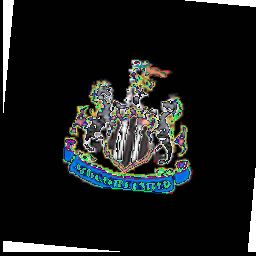

In [44]:
nparray = image_datasets['train'][2][0].cpu().numpy() 
image = transforms.ToPILImage()(image_datasets['train'][2][0].cpu()).convert("RGB")
display(image)

In [45]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_batches = 0
            outputs = None
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Loading Bar
                if (phase == 'train'):
                    num_batches += 1
                    percentage_complete = ((num_batches * batch_size) / (dataset_sizes[phase])) * 100
                    percentage_complete = np.clip(percentage_complete, 0, 100)
                    print("{:0.2f}".format(percentage_complete), "% complete", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # TODO: try removal
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                predicted = torch.max(outputs.data, 1)[1] 
                running_correct = (predicted == labels).sum()
                running_corrects += running_correct
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            
            epoch_acc = running_corrects / dataset_sizes[phase]
            #epoch_acc = sum(epoch_acc) / len(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc.item()))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [46]:
from torchvision import models
from torch.optim import lr_scheduler

model_ft = models.squeezenet1_1(weights=True)
model_ft.num_classes = 20 #this is am important compoent of the output model
model_ft.classifier._modules["1"] = nn.Conv2d(512, model_ft.num_classes, kernel_size=(1, 1))
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft.to(device), criterion, optimizer_ft, exp_lr_scheduler, 10)

C:\Users\amana\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 10.0486 Acc: 0.8544
val Loss: 0.1648 Acc: 0.9470
Epoch 1/9
----------
train Loss: 0.1499 Acc: 0.9583
val Loss: 0.0009 Acc: 1.0000
Epoch 2/9
----------
train Loss: 0.0133 Acc: 0.9961
val Loss: 0.0002 Acc: 1.0000
Epoch 3/9
----------
train Loss: 0.0115 Acc: 0.9962
val Loss: 0.0105 Acc: 0.9960
Epoch 4/9
----------
train Loss: 0.0075 Acc: 0.9974
val Loss: 0.0003 Acc: 1.0000
Epoch 5/9
----------
train Loss: 0.0085 Acc: 0.9974
val Loss: 0.0000 Acc: 1.0000
Epoch 6/9
----------
train Loss: 0.0084 Acc: 0.9973
val Loss: 0.0001 Acc: 1.0000
Epoch 7/9
----------
train Loss: 0.0035 Acc: 0.9988
val Loss: 0.0001 Acc: 1.0000
Epoch 8/9
----------
train Loss: 0.0021 Acc: 0.9994
val Loss: 0.0000 Acc: 1.0000
Epoch 9/9
----------
train Loss: 0.0013 Acc: 0.9996
val Loss: 0.0000 Acc: 1.0000
Training complete in 141m 23s


In [47]:
from sklearn.metrics import accuracy_score 

accuracy_scores = []

running_corrects = 0
outputs = None
for inputs, labels in dataloaders['test']:
    model_ft.eval()
    
    print(labels.numpy())
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    
    predicted = torch.max(outputs.data, 1)[1] 
    running_correct = (predicted == labels).sum()
    running_corrects += running_correct

accuracy = running_corrects / dataset_sizes['test']
print("Accuracy: " + str(accuracy.item()))

[19  3  2 16 17 14 16  5  9 12  2  5  4  2  8 17  2 11  6  5  0 13  7  8
  0 10 14  3 19 16  9 14]
[19  4 18 12 15 13  2  4 15  8 19 17 12  9 13 12  1 17 16  7 10 17  0  3
  2 12 12 15  3 14 10 14]
[18  1  7  7 16 13  3  7  9  4  4 13 12 17 15 19  2 15  1 19 16 18 13 18
  1  3 14  4  0  6 18  5]
[ 3  5 11 17  0 15 11  2  6 12 17  4  9  3  2  2 16  1 10 12  2  9  1 12
 14  2 18  7 14 10 14  8]
[ 0  7  3 19  3  9  9 13  1  5 19 16 13  5  3 12 15 10 17 13  4  7 13 12
 16  8  8 14  2  2  0 12]
[17  8  6 10 19  2  2  8 10 17  4  4  1  5  5 12 14  3  6 18 10 18 18  8
 11 16  7  8  2  8  5  1]
[11 14  4 17 19 11  3 16 10 10  7 14 11 17  8  6 10  1 17 10 11  0 10  6
  4  2 16 15 18  1  0 13]
[ 5 15  5 19 10  5  2 11 19 12  9 18  4 15  7 15  8 18 12 19  4 12  8  6
 14  6 18 10  7 18 19  4]
[14 13  5 18  9  1 11 15 13 10  5 10 18  2 13 14  8 13  2 17  7 14 15  4
 12  5  6  9 16 12  7  0]
[ 8  2  5  9  2  4 16 14  0 18 19  3  4 10 10  0 18 13  0  0 17 16 19 16
  0 18  6  0  6 16 11 16]
[ 4 13  0 